In [2]:
# imports
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
# plt.style.use(['seaborn-notebook'])

In [6]:
root = Path('..')

# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
# print(f"{sys.executable = }")

from utils import spaths
import sf_nets.models as models
import sf_nets.datasets as datasets
from utils.mpl_utils import coord_grid

# Dataset

In [135]:
name_ds = 'LogSin2'

In [136]:
data_path = root / 'data' / name_ds
model_path = root / 'results' / 'models' / name_ds.lower()

## Path

In [100]:
times, path = torch.load(data_path / 'raw' / 'path.pt')
len(path)

40001

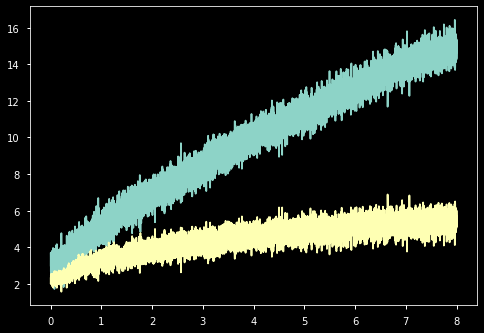

In [15]:
plt.plot(times, path);

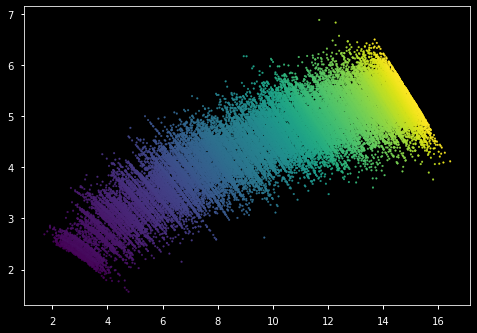

In [16]:
plt.scatter(*path.T, s=3, c=times);

## Training dataset

In [17]:
train_ds = datasets.LogSin2(root / 'data')

In [18]:
np.any(train_ds == np.nan)

False

In [47]:
len(train_ds.data)

2680

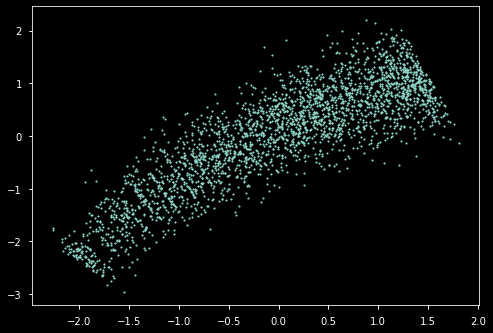

In [19]:
plt.scatter(*train_ds.data.T, s=3);

### Timescale spearation

In [22]:
covis = np.array([covi.detach().numpy() for dp, covi in train_ds])
covis.shape

(2680, 2, 2)

In [23]:
data_evals, data_evecs = zip(*[np.linalg.eigh(covi) for covi in covis])  # zip(*...) is equiv to transposing :)
data_evals, data_evecs = 1/np.array(data_evals), np.array(data_evecs)

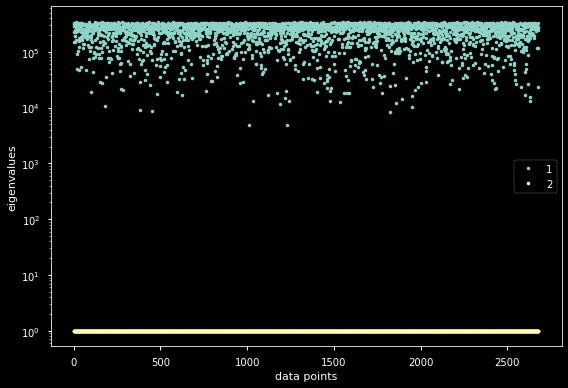

In [24]:
fig, ax = plt.subplots()
for n, e_val in enumerate(data_evals.T):
    ax.plot(e_val/data_evals.T[-1], '.', label=f"{n+1}")
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

# Trained models

In [25]:
model_types = ['test', 'simple']

In [223]:
series_list = []
for file in os.listdir(model_path):
    fpath = Path(file)
    if fpath.suffix == '.pt' and any(mt in fpath.stem for mt in model_types):
        model_data = torch.load(model_path / fpath.name)
        par_dict = {
            key:val
            for key, val in model_data['info']['config'].items()
            if key in {'max_epochs'}
        }
#         par_dict['layers (i,l,[h])'] = model_data['state']['best_model_dict'].keys()
#         par_dict['train_size'] = model_data['info']['config']['loader']['train_size']
#         par_dict['valid_size'] = model_data['info']['config']['loader']['valid_size']
        par_dict['features'] = model_data['info'].get('features', [])
        pruning = model_data['info']['config'].get('pruning')
        par_dict['sparsity'] = model_data['best']['sparsity'] if pruning else 0.0
        par_dict['valid_loss'] = model_data['history']['valid_losses'][model_data['best']['epoch']-1]
        par_dict['model_id'] = fpath.stem
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
(
models_df.set_index('model_id')
         .sort_values(by='model_id')
         .style.format({
             'sparsity': '{0:.0%}',
             'valid_loss': '{:.2}',
             'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
             'burst_dt': '{:.0e}',
             'burst_size': '{:.0e}'
         })
         .set_properties(**{'font-size': '12pt',})
)

,max_epochs,features,sparsity,valid_loss
model_id,,,,
test_0,6000,"[2, 4, 1, 4, 2]",0%,0.073
test_1,10000,"[2, 8, 1, 8, 2]",0%,0.019
test_mah_0,200,"[2, 4, 1, 4, 2]",0%,2.4
test_mah_1,8000,"[2, 4, 1, 4, 2]",0%,0.037
test_mse_1,2000,"[2, 4, 1, 4, 2]",0%,0.068
test_mse_2,2000,"[2, 6, 1, 6, 2]",0%,0.065


## Loss

In [225]:
model_id = 'test_mah_1'

In [226]:
model_data = torch.load(model_path /f'{model_id}.pt')
print(f'{model_data.keys() = }')

model_data.keys() = dict_keys(['id', 'info', 'best', 'history'])


In [227]:
train_losses = model_data['history']['train_losses']
valid_losses = model_data['history']['valid_losses']
checkpoints = model_data['history']['checkpoints']
epochs = range(1, model_data['info']['config']['max_epochs']+1)
best_epoch = model_data['best']['epoch']

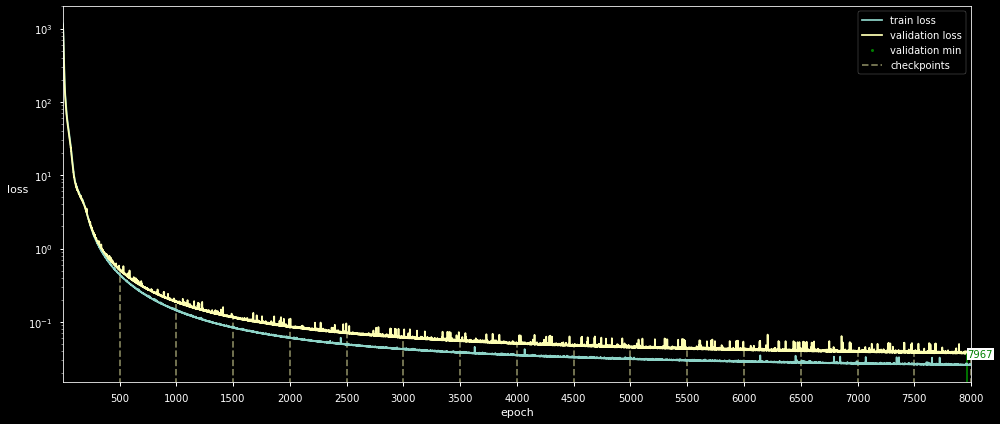

In [228]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
smallest_loss = valid_losses[best_epoch-1]
plt.vlines(x=best_epoch, ymin=0, ymax=smallest_loss, color='g')
ax.plot(best_epoch, smallest_loss, 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch+2, .9*smallest_loss, f'{best_epoch}', rotation=0, color='g', bbox={'fc': 'w', 'ec':'None', 'boxstyle':'Square, pad=0.1'})

ax.set_xlim([epochs[0], epochs[-1]+1])
# ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids)
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
fig.savefig(root / f"results/figs/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

## Load Model

In [229]:
model = models.SimpleAutoencoder(**model_data['info']['arguments'])
model_dict = 'model_dict'

In [230]:
def remove_mask(model_dict):
    mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'), model_dict.items()))
    orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'), model_dict.items()))
    rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')), model_dict.items()))
    state_dict = {
        key.replace('_orig',''): val_orig * val_mask
        for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
    }
    return {**state_dict, **rest}

In [231]:
check_epoch = 'best'

In [232]:
if check_epoch == 'best':
    state_dict = remove_mask(model_data['best']['model_dict'])
    check_epoch = best_epoch
else:
    check_dict = torch.load(model_path / f'{model_id}' / f'state_at_{check_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])

In [233]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [234]:
model.eval();

## Reconstruction visualization

In [235]:
rec_train_data = model(train_ds.data)[0]
train_data_np = train_ds.data.detach().numpy()
rec_train_data_np = rec_train_data.detach().numpy()

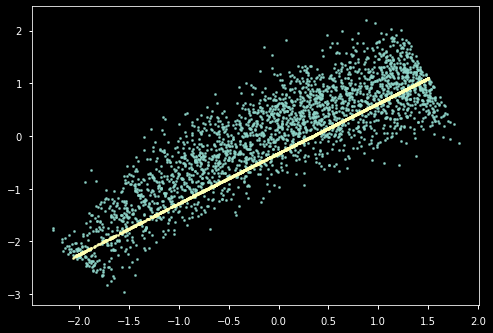

In [236]:
plt.scatter(*train_data_np.T, s=5)
plt.scatter(*rec_train_data_np.T, s=5);

## Encoder accuracy

In [237]:
test_ds = datasets.LogSin2(root / 'data', train=False)
test_data_np = test_ds.data.detach().numpy()

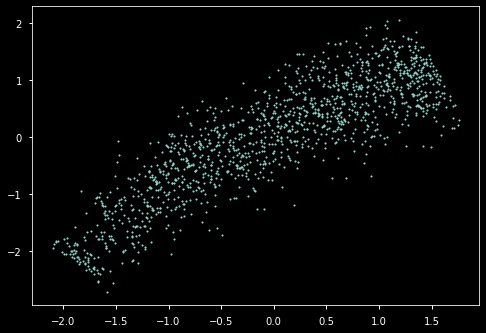

In [238]:
plt.scatter(*test_data_np.T, s=3);

In [239]:
dt = train_ds.dt
sde = train_ds.system.sde
slow_map = train_ds.system.slow_map

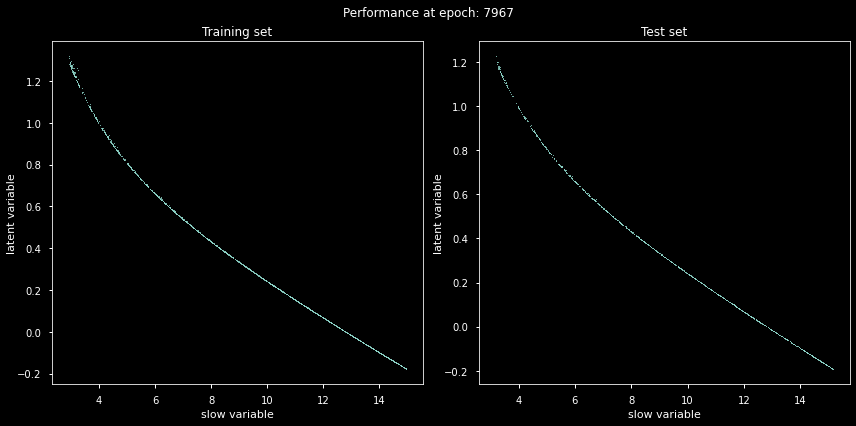

In [240]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

train_test_data = [train_ds.data, test_ds.data]
for ax, data, title in zip(axs, train_test_data, ['Training set', 'Test set']):
    slow_var = slow_map(data.detach().numpy().T)
    lat_var = model(data)[1].detach().numpy()
    try:
        ax.scatter(slow_var, lat_var.T, s=.5)
    except ValueError:
        print('Latent layer too large.')
        plt.close(fig)
    
    ax.set_title(f'{title}')
    ax.set_ylabel('latent variable', labelpad=0)
    ax.set_xlabel('slow variable')

fig.tight_layout()

fig.suptitle(f'Performance at epoch: {check_epoch}')
fig.subplots_adjust(top=0.9)
fig.savefig(root / f"results/figs/{model_id}_slowvar.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

In [241]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [216]:
start = test_data_np[1000:1002]
tspan = (0, 1)

test_sol = em.solve(sde, start, tspan, dt)

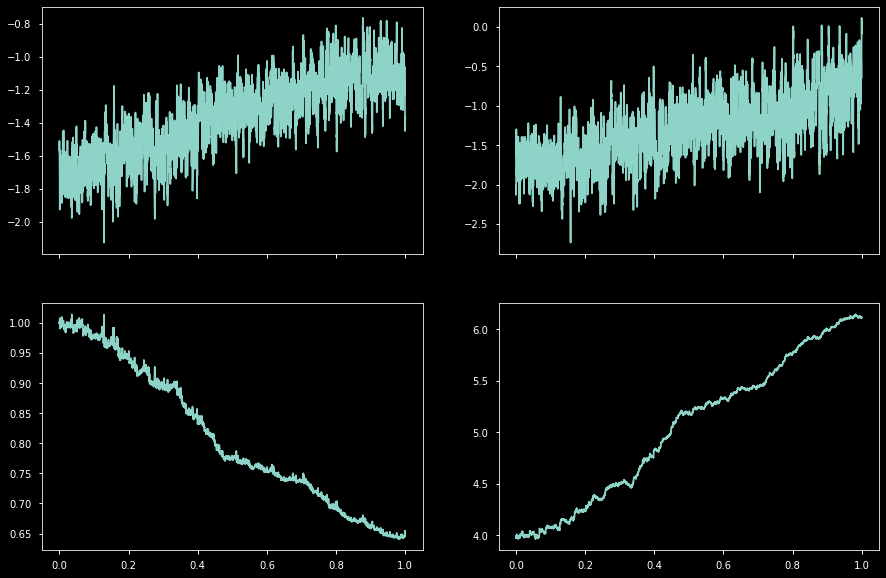

In [242]:
test_path = test_sol.p[0].T
t = np.linspace(*tspan, len(test_path.T))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10), sharex=True)

axs[0,0].plot(t, test_path[0]);
axs[0,1].plot(t, test_path[1]);

data = torch.from_numpy(test_path.T).to(dtype=torch.float)
lat_var = model(data)[1].detach().numpy()
axs[1,0].plot(t, lat_var);
axs[1,1].plot(t, slow_map(test_path));